In [33]:
from typing import Sequence, Tuple, List
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cirq
from ansatz import CylicQAOAAnsatz, edge_operator, maxcut_hamiltonian

In [34]:
def func_max(p, gamma, beta) -> float:
    """Maximize the function given the starting values of gamma and beta."""

    qs = cirq.LineQubit.range(2 * p + 2)
    bitstring = [True] * len(qs)
    qubit_graph = nx.Graph()
    for i in range(len(qs) - 1):
        qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
    #hamiltonian = maxcut_hamiltonian(qubit_graph)
    observable = -1.0 * edge_operator(qs[p], qs[p+1])
    qaoa_ansatz = CylicQAOAAnsatz(qubit_graph, observable)

    def objective_callback(vars: np.ndarray):
        assert vars.size % 2 == 0
        
        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        return qaoa_ansatz.energy(gammas, betas)

    def gradient_callback(vars:np.ndarray):
        assert vars.size % 2 == 0

        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        gamma_grad, beta_grad = qaoa_ansatz.energy_grad(gammas, betas)
        return np.concatenate((gamma_grad, beta_grad))

    vars0 = np.concatenate((gamma, beta))
    #print(gamma.shape, beta.shape, vars0.shape)
    # TODO Try Powell
    # TODO Try many random initial parameters
    opt_result = minimize(objective_callback, vars0, method="Powell")
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    return objective_callback(opt_result.x)


def func_max_random_starts(p, repetitions) -> float:
    """Maximize the function with different sets of starting parameters.
    Returns only the best one."""

    gammas = np.random.rand(repetitions, p)
    betas = np.random.rand(repetitions, p)
    f_maxs = []
    for i in range(repetitions):
        f_maxs.append(func_max(p, gammas[i, :], betas[i, :]))
    return np.min(f_maxs) # The minimum is the best one because we are maximizing, so we use -H.


ps = range(1, 6)
f_max = []
for p in ps:
    print(f"p = {p}")

    # Optimize the expectation value using Scipy's optimizer.
    gammas = np.random.rand(p)
    betas = np.random.rand(p)
    f_max.append(func_max_random_starts(p, 10))

df = pd.DataFrame({"p": ps, "f_max": f_max})
df.set_index("p", inplace=True)
print(df.head())

p = 1
p = 2
p = 3
p = 4
p = 5
      f_max
p          
1 -0.750000
2 -0.833302
3 -0.874763
4 -0.888553
5 -0.915846


In [35]:
df.to_csv("cycle_maxima.csv")

In [36]:
def exact_f_max(p):
    """See section 4 of QAOA paper."""

    return (2 * p + 1) / (2 * p + 2)

exact_maxima = np.array([exact_f_max(p) for p in ps])

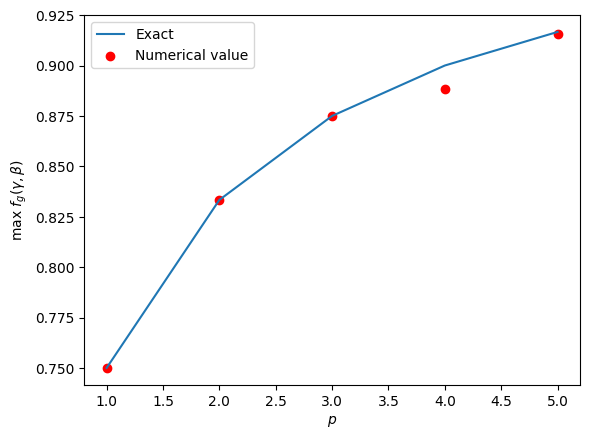

In [37]:
fig, ax = plt.subplots()
ax.plot(ps, exact_maxima, '-', label="Exact")
ax.scatter(ps, -1.0 * np.array(f_max), c="red", label="Numerical value")
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"max $f_g(\gamma, \beta)$")
plt.legend()
plt.savefig("maxima.pdf")